Tracks in MIDIFiles/Happy Birthday MIDI.mid:
	Electric Piano
Tracks in MIDIFiles/Happy Birthday MIDI_Transposed.mid:
	Piano, Electric Piano 
Tracks in MIDIFiles/Happy Birthday MIDI_changedTime.mid:
	Piano, Electric Piano 
Tracks in MIDIFiles/Happy Birthday MIDI_changedNotes.mid:
	Piano, Electric Piano 
PTD(A, A) = 3.6414768538993387
PTD(A, B) = 3.7022102334273517
PTD(A, C) = 3.795572570105268
PTD(A, D) = 4.098499139203347
PTD(B, A) = 3.702210233427352
PTD(B, B) = 3.581628534770889
PTD(B, C) = 3.708673431249798
PTD(B, D) = 3.9798322892104743
PTD(C, A) = 3.795572570105268
PTD(C, B) = 3.708673431249798
PTD(C, C) = 3.801340362913599
PTD(C, D) = 4.074427573452112
PTD(D, A) = 4.098499139203347
PTD(D, B) = 3.9798322892104747
PTD(D, C) = 4.074427573452112
PTD(D, D) = 4.186505086336282


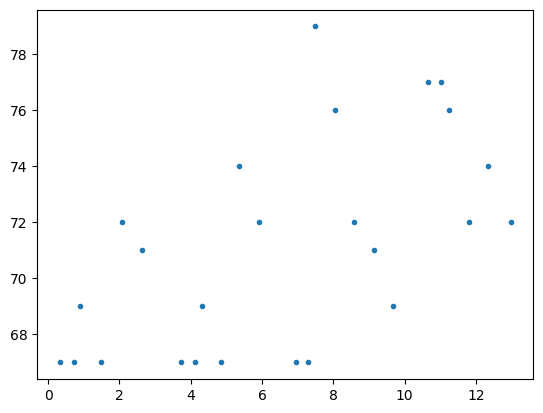

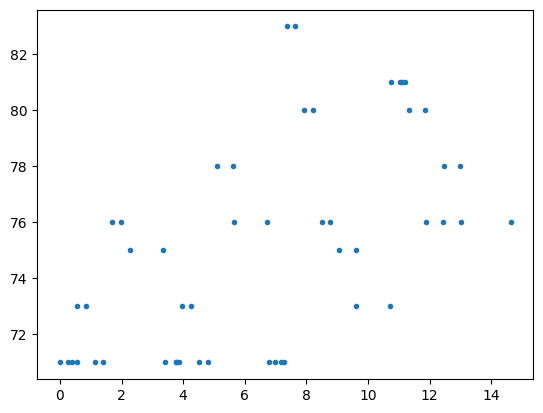

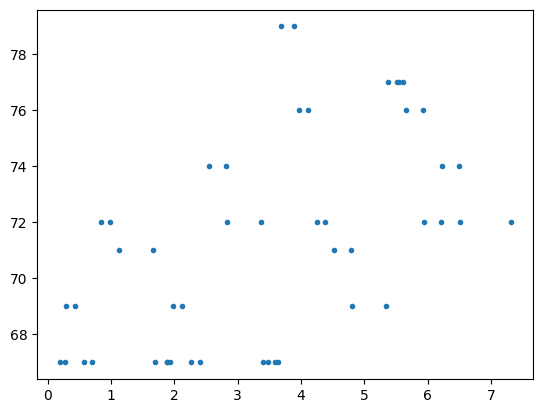

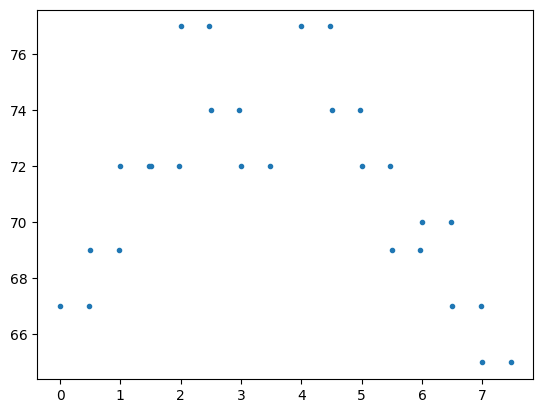

In [2]:

from matplotlib import pyplot as plt
import numpy as np
import mido as md
import os



def midiTrackToNoteSequence(track, timeSignature, mid):
    sequence = []
    notes = {}
    prevTime = 0.0
    for msg in track:
        if msg.is_meta:
            if msg.type == "time_signature":
                timeSignature["numerator"] = msg.numerator
                timeSignature["denominator"] = msg.denominator
            elif msg.type == "set_tempo":
                usPerQuarter = msg.tempo
                sPerQuarter = usPerQuarter / 1e6
                timeSignature["tempo"] = 60 / sPerQuarter * \
                    timeSignature["denominator"] /4
        else:
            time = msg.time / mid.ticks_per_beat * \
                60 / timeSignature["tempo"] + \
                prevTime
            
            if msg.type == "note_on" or msg.type =="note_off":

                note = {
                    "channel": msg.channel,
                    "note": msg.note,
                    "velocity": msg.velocity,
                    "time": time,
                    "end": -1
                }
                key = "{:02}_{:03}".format(msg.channel, msg.note)

                if msg.type == "note_on":
                    if not key in notes:
                        notes[key] = []
                    else: 
                        prevNote = notes[key][-1]

                        if prevNote["end"] < 0:
                            prevNote["end"] = time

                    notes[key].append(note)
                else:
                    if key in notes:
                        prevNote = notes[key][-1]

                        prevNote["end"] = time

            prevTime = time

    for key in notes.keys():
        for note in notes[key]:
            noteLength = 1.0

            if note["end"] >= 0.0:
                noteLength = note["end"] - note["time"]

            sequence.append({
                "time": note["time"],
                "number": note["note"],
                "length": noteLength
            })

    sequence.sort(key = lambda note: note["time"])

    return sequence

def findTrackName(track):
    for msg in track:
        if msg.type == "track_name":
            return msg.name
    return None

def printTrackNames(midiFilename):
    mid = md.MidiFile(midiFilename)

    print("Tracks in {}:".format(midiFilename))

    for track in mid.tracks:
        print("\t{}".format(findTrackName(track)))

def readMidiFileIntoPointSet(filename, trackName = None, singleNote = False):
    mid = md.MidiFile(filename)

    timeSignature = {
        "numerator": 4,
        "denominator": 4,
        "tempo": 60
    }

    noteTimes = []
    noteNumbers = []
    noteLengths = []

    sequence = []

    for track in mid.tracks:
        if trackName:
            currentName = findTrackName(track)

            if currentName != trackName:
                continue

        sequence.extend(midiTrackToNoteSequence(track, timeSignature, mid))

    sequence.sort(key = lambda note: note["time"])

    SMALL_DT = 0.01

    for note in sequence:
        if singleNote and len(noteTimes) > 0:
            if note["time"] - noteTimes[-1] < SMALL_DT:
                continue

        
        noteTimes.append(note["time"])
        noteNumbers.append(note["number"])
        noteLengths.append(note["length"])

    return {
        "t": np.array(noteTimes),
        "n": np.array(noteNumbers),
        "l": np.array(noteLengths),
        "timeSignature": timeSignature
    }

def proportionalTransportationDistance(set_A, set_B):
    w = set_A["l"]
    u = set_B["l"]

    W = w.sum()
    U = u.sum()

    t1 = (set_A["t"] - set_A["t"].min()) / (set_A["t"].max() - set_A["t"].min())
    t2 = (set_B["t"] - set_B["t"].min()) / (set_B["t"].max() - set_B["t"].min())
    p1 = set_A["n"] - (set_A["n"] * w/W).sum()
    p2 = set_B["n"] - (set_B["n"] * u/U).sum()

    f = w.reshape(-1, 1) * u.reshape(1, -1)/U
    d = np.sqrt(
        9 * (t1.reshape(-1, 1) - t2.reshape(1, -1)) ** 2 +
        (p1.reshape(-1, 1) - p2.reshape(1, -1)) ** 2
    )

    return (f*d).sum() / W

def otherDistance(set_A, set_B):
    w = set_A["l"] / set_A["l"].sum()
    u = set_B["l"] / set_B["l"].sum()

    t1 = (set_A["t"] - set_A["t"].min()) / (set_A["t"].max() - set_A["t"].min())
    t2 = (set_B["t"] - set_B["t"].min()) / (set_B["t"].max() - set_B["t"].min())
    p1 = set_A["n"] - (set_A["n"] * w).sum()
    p2 = set_B["n"] - (set_B["n"] * u).sum()

    f = w.reshape(-1, 1) * u.reshape(1, -1)
    d = np.sqrt(
        (t1.reshape(-1, 1) - t2.reshape(1, -1)) ** 2 +
        (p1.reshape(-1, 1) - p2.reshape(1, -1)) ** 2
    )

    dargmin0 = d.argmin(axis=0)
    dargmin1 = d.argmin(axis=1)

    dmin0 = d[dargmin0, :]
    dmin1 = d[:, dargmin1]
    fmin0 = f[dargmin0, :]
    fmin1 = f[:, dargmin1]

    return (fmin0 * dmin0).sum() + (fmin1 * dmin1).sum()

printTrackNames("MIDIFiles/Happy Birthday MIDI.mid")
printTrackNames("MIDIFiles/Happy Birthday MIDI_Transposed.mid")
printTrackNames("MIDIFiles/Happy Birthday MIDI_changedTime.mid")
printTrackNames("MIDIFiles/Happy Birthday MIDI_changedNotes.mid")

set_A = readMidiFileIntoPointSet("MIDIFiles/Happy Birthday MIDI.mid")
set_B = readMidiFileIntoPointSet("MIDIFiles/Happy Birthday MIDI_Transposed.mid")
set_C = readMidiFileIntoPointSet("MIDIFiles/Happy Birthday MIDI_changedTime.mid")
set_D = readMidiFileIntoPointSet("MIDIFiles/TestPieceC.mid")

plt.figure()
plt.plot(set_A["t"], set_A["n"], '.')
plt.figure()
plt.plot(set_B["t"], set_B["n"], '.')
plt.figure()
plt.plot(set_C["t"], set_C["n"], '.')
plt.figure()
plt.plot(set_D["t"], set_D["n"], '.')

sets = {
    "A": set_A,
    "B": set_B,
    "C": set_C,
    "D": set_D
}

for key_A in sets.keys():
    for key_B in sets.keys():
        PTD = proportionalTransportationDistance(sets[key_A], sets[key_B])
        print("PTD({}, {}) = {}".format(key_A, key_B, PTD))    
